In [1]:
import pandas as pd
import pylab as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)warnings.filterwarnings('ignore')
import os

from sklearn import preprocessing
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
from scikitplot.metrics import plot_confusion_matrix

%matplotlib inline


In [2]:
from config import *
#Paths defined in python Config file

#Saas Paths
#raw_saas_path  
#proc_saas_path  

#RabbitMQ paths
#raw_evts_path  
#proc_evts_path  

#function for loading data
def load_data(csv_path):
    return pd.read_csv(csv_path,\
                    parse_dates=['timestamp'] ,index_col=['timestamp'])#comment if timestamp indexing not wanted
                      

df = load_data(proc_saas_path)




In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 697 entries, 2019-05-22 11:25:00 to 2020-03-25 13:36:00
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     697 non-null    int64 
 1   event_type  697 non-null    object
 2   cl0         697 non-null    object
 3   cl1         697 non-null    object
 4   cl2         697 non-null    object
 5   cl3         697 non-null    object
 6   cl4         697 non-null    object
 7   count       697 non-null    int64 
dtypes: int64(2), object(6)
memory usage: 49.0+ KB


In [4]:

from sklearn.preprocessing import LabelEncoder
#For inverse_transform and transform, you have to do a little bit of hack.

from collections import defaultdict
d = defaultdict(LabelEncoder)

#With this, you now retain all columns LabelEncoder as dictionary.

# Encoding the variable
fit_df = df.apply(lambda x: d[x.name].fit_transform(x))

# Inverse the encoded
rev_df = fit_df.apply(lambda x: d[x.name].inverse_transform(x))

# Using the dictionary to label future data
new_df = df.apply(lambda x: d[x.name].transform(x))

In [5]:
df

,user_id,event_type,cl0,cl1,cl2,cl3,cl4,count
timestamp,,,,,,,,
2019-05-22 11:25:00,180009,PROFILE_UPDATED,343298,36,222737,214914,22780,2
2019-05-22 11:28:00,422262,PROFILE_UPDATED,14166,19939,21567,20948,11061,90
2019-05-22 20:02:00,180009,PROFILE_UPDATED,343298,36,222737,214914,22780,2
2019-05-22 20:02:00,422262,PROFILE_UPDATED,14166,19939,21567,20948,11061,6
2019-05-28 06:39:00,404132,PROFILE_CREATED,10260,192565,7035,323209,3444,1
...,...,...,...,...,...,...,...,...
2020-03-23 22:47:00,456890,PROFILE_UPDATED,235105,523036,266726,266534,237239,15
2020-03-24 22:47:00,290306,PROFILE_UPDATED,254048,255153,235387,392111,513034,3
2020-03-24 22:47:00,456890,PROFILE_UPDATED,235105,523036,266726,266534,237239,15


In [6]:
#new_df = new_df[{ 'count'}]
new_df

,user_id,event_type,cl0,cl1,cl2,cl3,cl4,count
timestamp,,,,,,,,
2019-05-22 11:25:00,2,2,33,32,22,12,33,1
2019-05-22 11:28:00,28,2,7,12,21,9,4,51
2019-05-22 20:02:00,2,2,33,32,22,12,33,1
2019-05-22 20:02:00,28,2,7,12,21,9,4,5
2019-05-28 06:39:00,20,0,2,8,55,34,43,0
...,...,...,...,...,...,...,...,...
2020-03-23 22:47:00,55,2,22,51,32,29,36,14
2020-03-24 22:47:00,11,2,28,30,26,44,60,2
2020-03-24 22:47:00,55,2,22,51,32,29,36,14


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV


# Split the dataset in two equal parts
#train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test = train_test_split(new_df, test_size=0.2, random_state=42)
#  abnormal novel observations
X_outliers =new_df[ new_df['count'] > 60 ]

# fit the model
clf = IsolationForest(n_estimators=10, max_samples='auto', contamination='auto',\
                     bootstrap=False, n_jobs=-1,\
                    random_state=42, verbose=0, behaviour="new")
clf.fit(X_train)


C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


IsolationForest(behaviour='new', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples='auto', n_estimators=10,
                n_jobs=-1, random_state=42, verbose=0, warm_start=False)

In [15]:

# Predict if a particular sample is an outlier using all features for higher dimensional data set.
# The prediction returns 1 if sample point is inlier. If outlier prediction returns -1

#predictions on the training set
y_pred_train = clf.predict(X_train)
#Find the index of anomalies 
#here points classified -1 are anomalous
X_train['anomaly']=y_pred_train
outliers=X_train.loc[X_train['anomaly']==-1]
outlier_index=list(outliers.index)



C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [16]:
y_pred_outliers = clf.predict(X_outliers) #predictions on the 'known' outliers
X_outliers['anomaly']=y_pred_outliers
outliers3=X_outliers.loc[X_outliers['anomaly']==-1]
outlier_index3=list(outliers3.index)


C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


We know that the outlier set set contains only anormal observations from the distribution  So, the outliers prediction should classify all points as anormal  . 

 We can see that some of the outliers lying within the normal observation sets were correctly classified as regular observations, with a few of them being misclassified. What we could do is to try different parameter specifications (contamination, number of estimators, number of samples to draw for trining the base estimators, etc.) to get a better fit. But for now, these results are satisfactory.

0    82
1    58
Name: anomaly, dtype: int64


C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


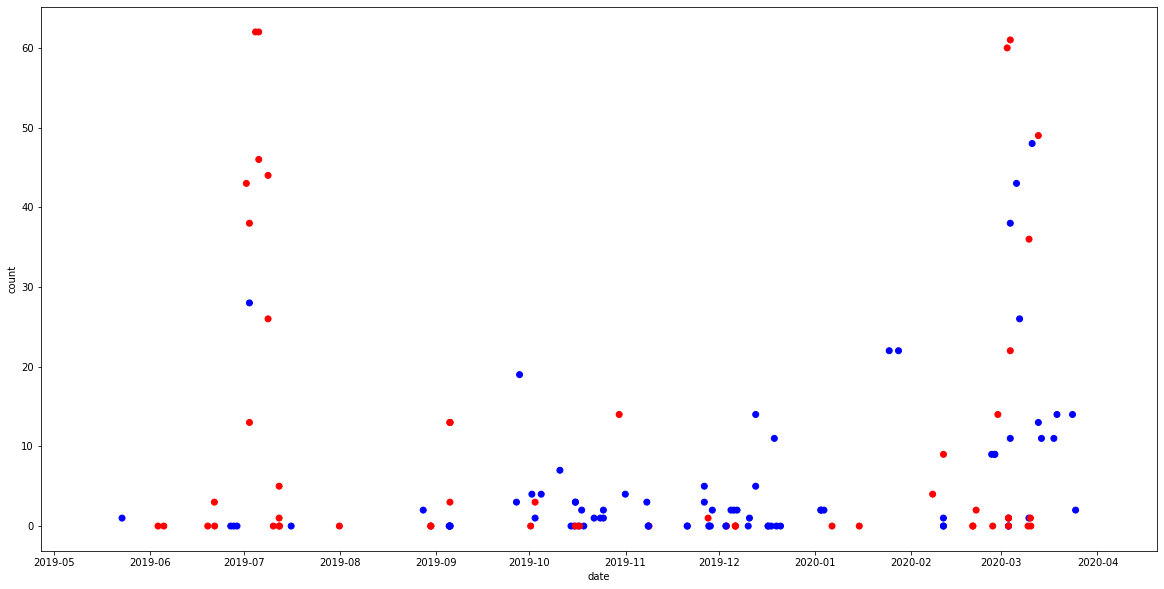

In [17]:
#Average anomaly score of X of the base classifiers.
#The anomaly score of an input sample is computed as the mean anomaly score of the trees in the forest.
#The measure of normality of an observation given a tree is the depth of the leaf containing this observation, 
#which is equivalent to the number of splittings required to isolate this point.

#In case of several observations n_left in the leaf, the average path length of a n_left samples isolation tree 
#is added.
# predict if a given value is an outlier or not; 1=inliner; -1=outlier
X_test['anomaly'] = clf.predict(X_test) 


X_test.loc[X_test['anomaly'] == 1, 'anomaly'] = 0  # if anomaly column value is 1, replace with 0
X_test.loc[X_test['anomaly'] == -1, 'anomaly'] = 1  # if anomaly column value is -1, replace with 1

print(X_test['anomaly'].value_counts()) 
# 0(not an anomaly)  and  1(anomaly)

plt.figure(figsize=(20,10))
plt.scatter(x=X_test.index, y=X_test['count'], color=np.where(X_test['anomaly'] == 1, 'red', 'blue'))#if 1 red , if 0 blue aka noormal
plt.xlabel('date')
plt.ylabel('count')
plt.show()

